## Carga de librerias y dataset

Las librerias necesarias para este notebook serán las siguientes importadas:

In [1]:
from collections import Counter # se usará? la saqué del notebook "pandas introduccion"
import requests # se usará? la saqué del notebook "pandas introduccion"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score
from ipywidgets import Button, IntSlider, interactive


from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.cluster import KMeans

Tambien leemos el dataset, que está en formato CSV desde Google Drive.

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("fiufip_dataset.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
        import pandas as pd


In [3]:
df = pd.read_csv("fiufip_dataset.csv")

Se renombra a las columnas en un formato mas comodo de manejar.

# Análisis Exploratorio

## Eliminación de instancias duplicadas

Antes de empezar, eliminamos las duplicadas

In [4]:
size_antes = len(df)
df = df.drop_duplicates()
size_despues = len(df)
print(f'se eliminaron: {size_antes-size_despues} filas duplicadas')

se eliminaron: 3465 filas duplicadas


## ¿Como es la distribución de los valores adquisitivos?

Primero detallemos cuantas personas han respondido la encuesta

In [5]:
print("Esta encuesta ha sido respondida por:", len(df), "personas")

Esta encuesta ha sido respondida por: 29096 personas


Veamos en prinicipio la cantidad y la proporción de personas que han declarado tener alto u bajo valor adqusitivo.

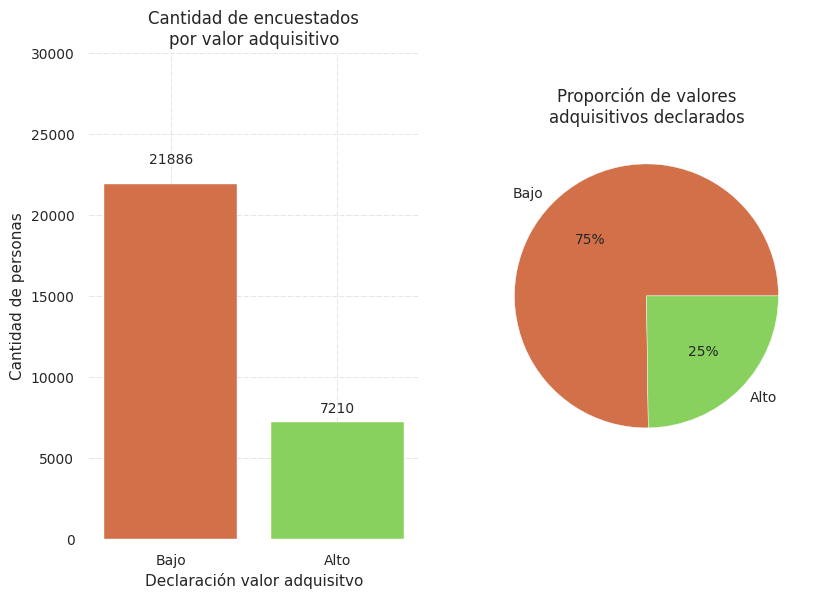

In [6]:
fig, axes = plt.subplots(ncols = 2, dpi=100)
fig.tight_layout()

axes_0 = axes[0].bar(['Bajo', 'Alto'], df.tiene_alto_valor_adquisitivo.value_counts().values,  color=['#D17049',"#89D15E"])

axes[1].pie(df.tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
axes[1].set_title("Proporción de valores\nadquisitivos declarados")

axes[0].set_ylabel("Cantidad de personas")
axes[0].set_xlabel("Declaración valor adquisitvo")
axes[0].set_title("Cantidad de encuestados\npor valor adquisitivo")                  
                  
for rect in axes_0:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')
        

axes[0].set_yticks(np.arange(0,35000, 5000))
axes[0].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Podemos observar que solo un 25% (7210 personas) han declarado tener alto valor adquisitivo. A prori esta variable por si sola no nos aporta mucho.

¿JUSTIFICACIÓN CORRECTA?: *si la proporción era maso menos igual,quizás algo podemos decir, pero no fue el caso*

## ¿Cómo es la distribución de los Barrios?

Para responder ésta pregunta primero veamos cuantos son los barrios que han sido cargados


In [7]:
print('Cantidad barrios únicos: ', df.barrio.value_counts().nunique())

Cantidad barrios únicos:  36


Una altisima cantidad de barrios ingresados, es decir, una alta cardinalidad para ésta feature.

Veamos la cantidad de encuestados por barrio

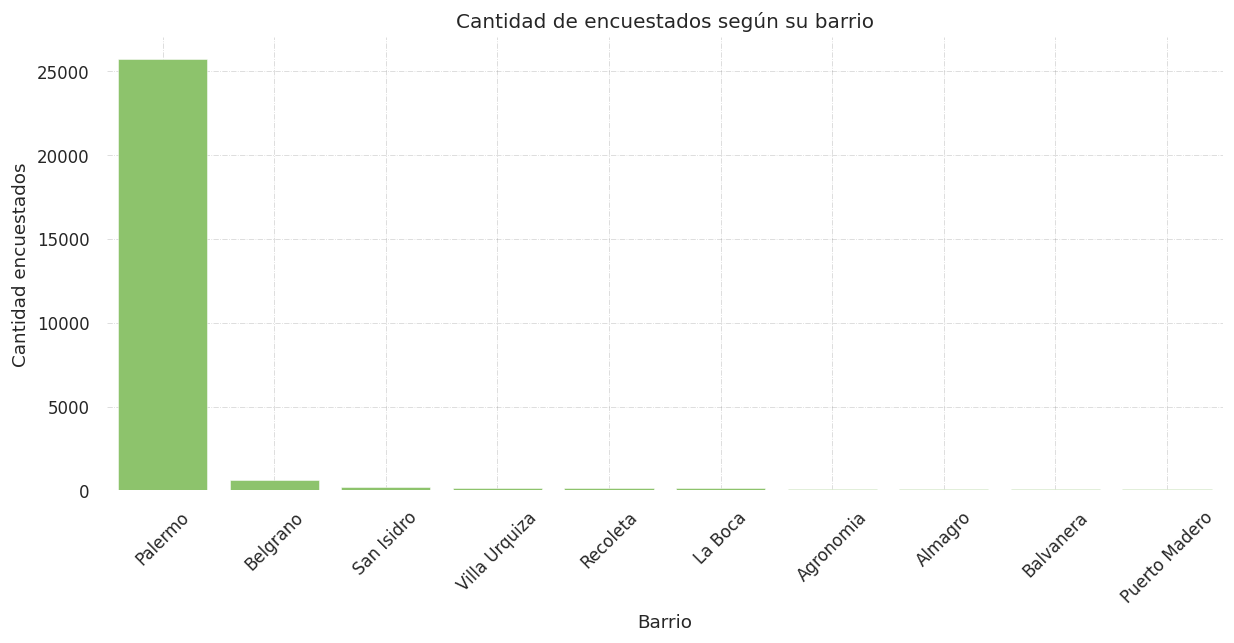

In [8]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
sns.countplot(
    x="barrio",
    data=df,
    order=df["barrio"].value_counts().iloc[:cantidad_barrios_visualizados].index,
    color='#89D15E',
)

plt.ylabel("Cantidad encuestados")
plt.xlabel("Barrio")
plt.title("Cantidad de encuestados según su barrio")
plt.xticks(rotation=45)

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Lo cual se peude notar una altisima cantidad de encuestados provenientes de Palermo, por ende no podemos decir mucho a priori. Es mas, notar que solo graficamos 10 barrios de los 37 posibles que hay, en orden descendiente.

Si nos guiamos con proporciones

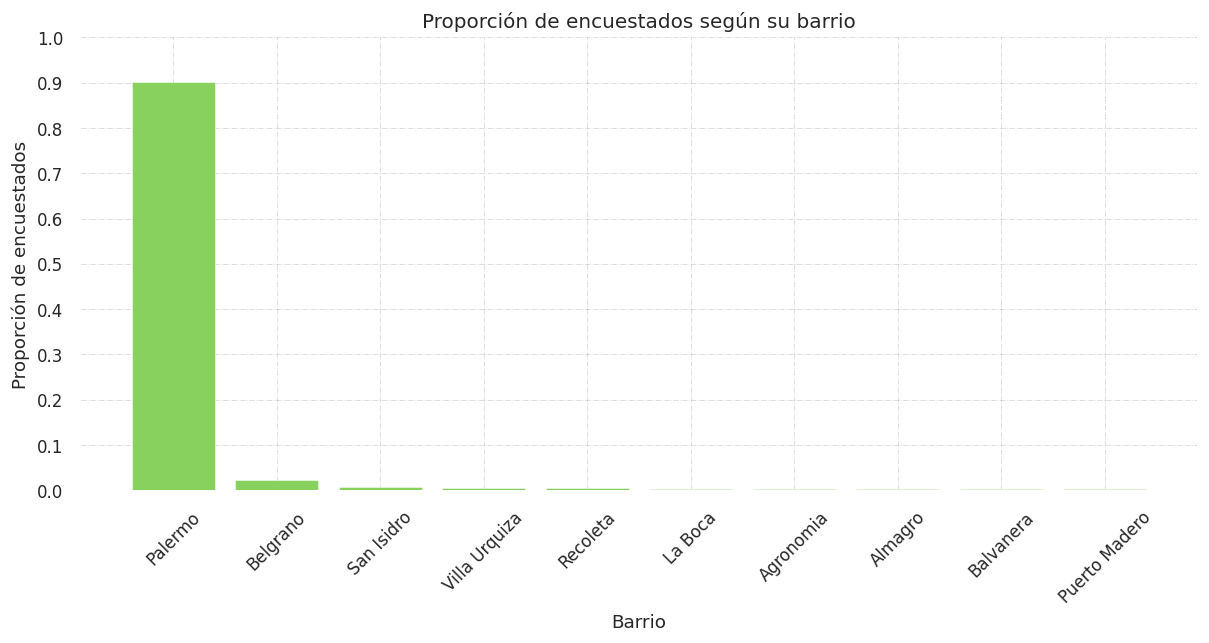

In [9]:
cantidad_barrios_visualizados = 10

plt.figure(dpi=120,figsize =(12, 5))
barrios = (
    df['barrio']
    .value_counts(normalize=True)
    .sort_values(ascending=False)
)
ax = plt.bar(barrios.iloc[:cantidad_barrios_visualizados].index, barrios.iloc[:cantidad_barrios_visualizados].values, color = '#89D15E')

plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.ylabel("Proporción de encuestados")
plt.xlabel("Barrio")
plt.title("Proporción de encuestados según su barrio")
plt.xticks(rotation=45)
plt.yticks(np.arange(0,1.1, 0.1))
plt.show()

De la misma forma, era evidente observar que casi un 90% de las personas que fueron encuestadas fueron de Palermo y, en las demás comunas de la ciudad no llega ni al 1% de encuestados.

Podriamos averiguar la cantidad de personas en Palermo respecto si tienen alto nivel adquisito o no

### ¿En Palermo, hay inidicios de tener alto valor adquisitivo?

Teniendo en cuenta que Palermo es el barrio con mayor proporción de personas, preguntemosnos algo respecto valor adquisitivo

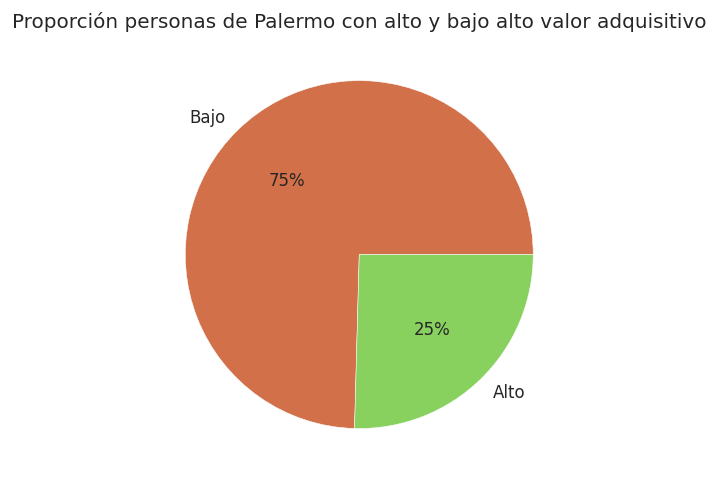

In [10]:
plt.figure(figsize=(6.4, 4.8), dpi=120)
plt.title('Proporción personas de Palermo con alto y bajo alto valor adquisitivo')
plt.pie(df[df.barrio == 'Palermo'].tiene_alto_valor_adquisitivo.value_counts().sort_index(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Es decir un 25% de las personas que habitan en la comuna de Palermo de CABA tienen un alto nivel adquisitivo. Pero a prori no nos dice mucha información ni responde nuestra pregunta. Quizás nos podrá ser interesante para futuras relaciones entre diferentes features.

Es conclusión si respondemos a la pregunta inicial que nos realizamos *"¿Cómo es la distribución de los Barrios?"*
Vimos que es una distribución poco equitativa y que a prori no nos muestra mucha ifnormación ni podemos buscar algun patón relacionandolos con el valor adquisitivo.

Tambien vimos la relacion con el barrio Palermo, y concluimos que vivir en Palermo no implica tener declarado un alto valor adquisitivo.


## ¿Hay relación entre la Edad y el Genero?

Primero preguntemosno y veamos cómo se distribuyen dichas variables

### ¿Cómo se distribuye los generos?

Veamos con grafico simple la cantidades de generos que han respondido la encuesta

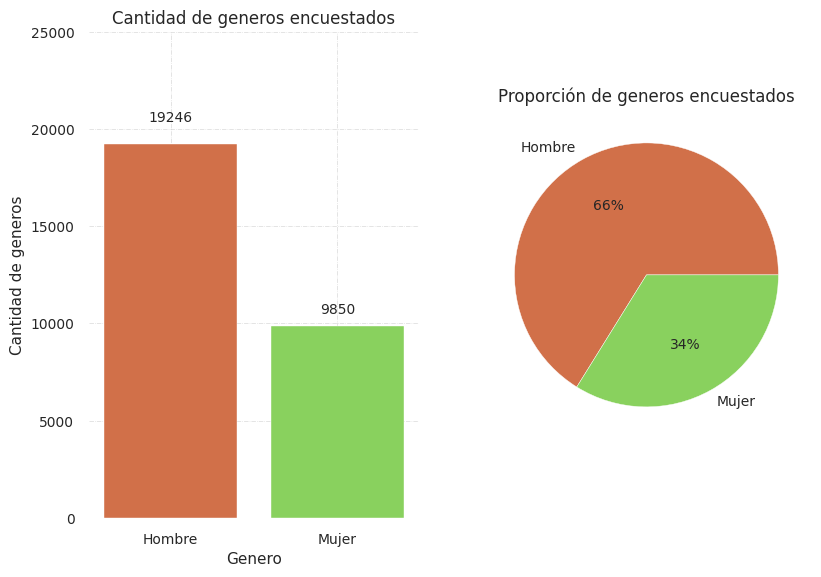

In [11]:
fig, axes = plt.subplots(ncols = 2, dpi=100)
fig.tight_layout()

axes_0 = axes[0].bar(['Hombre', 'Mujer'], df.genero.value_counts().values,  color=['#D17049',"#89D15E"])

axes[1].pie(df.genero.value_counts().values, labels= ['Hombre', 'Mujer'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
axes[1].set_title("Proporción de generos encuestados")

axes[0].set_ylabel("Cantidad de generos")
axes[0].set_xlabel("Genero")
axes[0].set_title("Cantidad de generos encuestados")

for rect in axes_0:
    height = rect.get_height()
    axes[0].text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom')
        

axes[0].set_yticks(np.arange(0,30000, 5000))
axes[0].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

Hay una un 66% de hombres encuestados que de mujeres. A prori podemos suponer que la encuesta le llegaron en mano a mas hombres que mujeres, aunque tambien nos habre otro escenario mas de posibilidades: quizás a las mujeres no les interesó responder la encuesta.

Veamos como se distribuye la edad en la encuesta

### ¿Hay missings en la edad?

Antes de analizar, nos preguntamos por los missings, chequemos las variables numericas del a misma

In [12]:
(df.edad < 0).any()

False

Es decir, no hay ninguna edad incongruente. Veamos la cantidad de missings

In [13]:
df.edad.isna().any()

False

Tampoco hay missings o valores **NaN**, prosegumos entonces con el analisis de las edades

### ¿Y cómo es la distribución de la edad?

Veamos primero las cantiades de edades unicas que tenemos:

In [14]:
print("Cantidad de edades unicas encuestadas son", df.edad.nunique())

Cantidad de edades unicas encuestadas son 73


Es decir, clarametne una variable continua, con alta cardinalidad. Veamos esto en graficos

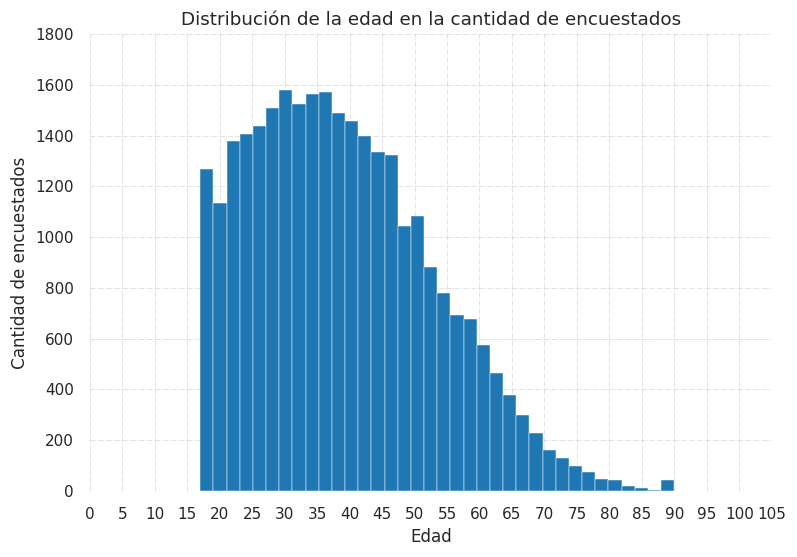

In [15]:
plt.figure(dpi=110)
bins_deseados = int(df.edad.nunique()/2)
plt.hist(df.edad, bins=bins_deseados, label="Edad")

plt.title("Distribución de la edad en la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad")
plt.xticks(np.arange(0,110, 5))
plt.yticks(np.arange(0,2000, 200))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Hay un amplio rango de edades, principalmente hay una mayor concentracion de personas que respondieron la encuesta entre 25 y 50 años aporximadamente.

Pero notamos que puede ser muy confuso este grafico, buscaremos discretizar por grupos de edades para ver mas claro lo que queremos transmitir

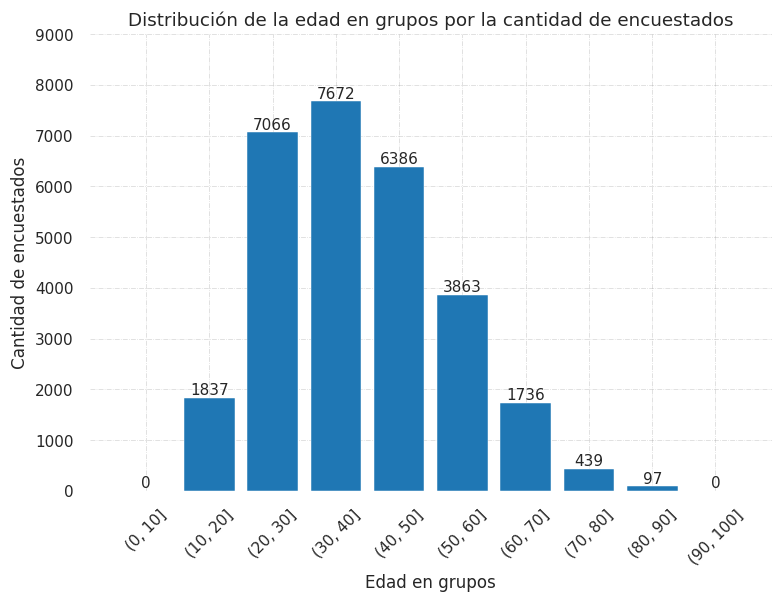

In [16]:
fig, ax = plt.subplots(dpi=110)
    
rango_edades =  np.arange(0,110,10)
cantidad_en_rango = pd.Series(pd.cut(df['edad'], bins = rango_edades).value_counts()).sort_index()

ploted = plt.bar(cantidad_en_rango.index.astype(str), cantidad_en_rango.values)

for rect in ploted:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height,
            '%d' % int(height),
            ha='center', va='bottom')

plt.title("Distribución de la edad en grupos por la cantidad de encuestados")
plt.ylabel("Cantidad de encuestados")
plt.xlabel("Edad en grupos")
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.tick_params('x',labelrotation=45)
plt.yticks(np.arange(0,9500, 1000))
plt.show()

En conclusión podemos observar tres grupos mayoritarios que respondieron la encuesta. En este caso de 20 a 50 años fueron los mas propensos.

### Veamos entonces la relación entre Edad y Genero 

Ahora que ya tenemos un panorama general de dichas variables, veamos la cantidad de encuestados por edad y genero.

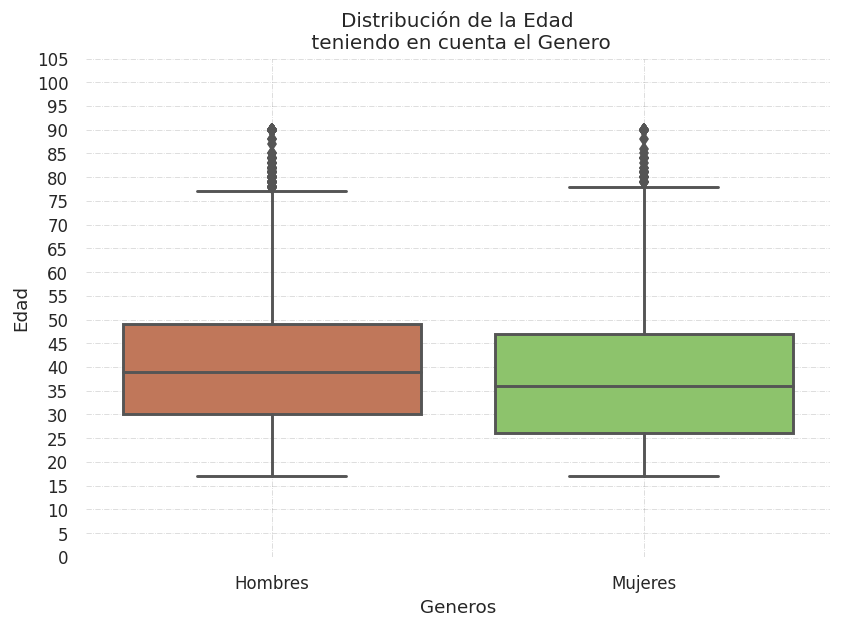

In [17]:
plt.figure(dpi=120)
plt.title("Distribución de la Edad\n teniendo en cuenta el Genero")
sns.boxplot(
    data=df,
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xlabel("Generos")
plt.xticks([False, True], ["Hombres", "Mujeres"])
plt.yticks(np.arange(0,110, 5))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

El cual se puede observar que la media de edad de ambos grupos encuestados no difiere tanto.

Es decir, que se mantiene la proproción de edades encuestados muy levemente. La diferencia a lo sumo serian 3 o 4 años, en otras palabras: hay mas jovenes mujeres que respondieron la encuesta en vez hombres, pero es una diferencia muy leve.
 

### ¿Hay igualdad de Genero en los valores adquisitivos declarados?

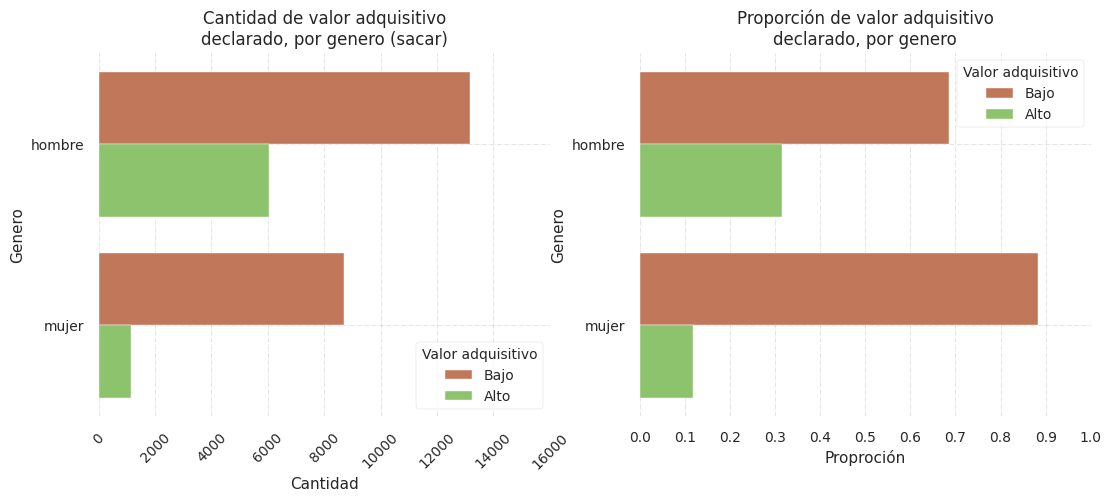

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)
colors = ['#D17049', "#89D15E"]

ploted_cero = sns.countplot(data=df, y='genero', hue='tiene_alto_valor_adquisitivo', ax=axes[0] , palette=colors)
axes[0].set_title("Cantidad de valor adquisitivo\ndeclarado, por genero (sacar)")
axes[0].set_xlabel("Cantidad")
axes[0].set_xticks(np.arange(0,18000, 2000))
axes[0].tick_params('x',labelrotation=45)

ploted_one = sns.barplot(
    data=df.groupby("genero")
    .tiene_alto_valor_adquisitivo.value_counts(normalize=True)
    .rename("Cantidades")
    .reset_index(),
    y='genero',
    x="Cantidades",
    hue='tiene_alto_valor_adquisitivo',
    ax=axes[1],
    palette=colors,
)
axes[1].set_xlabel("Proproción")
axes[1].set_title("Proporción de valor adquisitivo\ndeclarado, por genero")
axes[1].set_xticks(np.arange(0,1.1, 0.1))

for plot in [ploted_cero, ploted_one]:
    leg = plot.get_legend()
    leg.set_title("Valor adquisitivo")
    labs = leg.texts
    labs[0].set_text("Bajo")
    labs[1].set_text("Alto")
    plot.set_ylabel("Genero")
    plot.set_ylabel("Genero")
    plot.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()

Como podemos observar, y respondiendo a nuestra pregunta, no es equitativo la declaración del valor adquisitivo.

Hay una mayor proporción de hombres que declaran tener alto valor adquisitivo a comparación de las mujeres. Y si hablamos en cantidades, solo casi mil mujeres contra seismil quinientas de hombres han declarado tener altos ingresos.

**DEBATIR JUSTIFICACIÓN:**

**¿En conclusión, no parece ser una variable muy interesante?** por el bajo porcentaje que hay en la declaración de alto valor adquisitivo. Ademas teniendo en cuenta que, como ya vimos, habia un 66% de hombres encuestados, y el resto de mujeres lo cual se podria justificar esa diferencia de porcentaje de alto valor adquisitivo.

Ademas algo que notamos es que no influye mucho ser hombre y mujer para tener al to valor adquisitivo. Solo un 30% si sos hombre, y un 10% si sos mujer tendrias alto valor adquisitivo.

### ¿Hay un rango de Edades que dé indicios de tener alto valor adquisitivo?

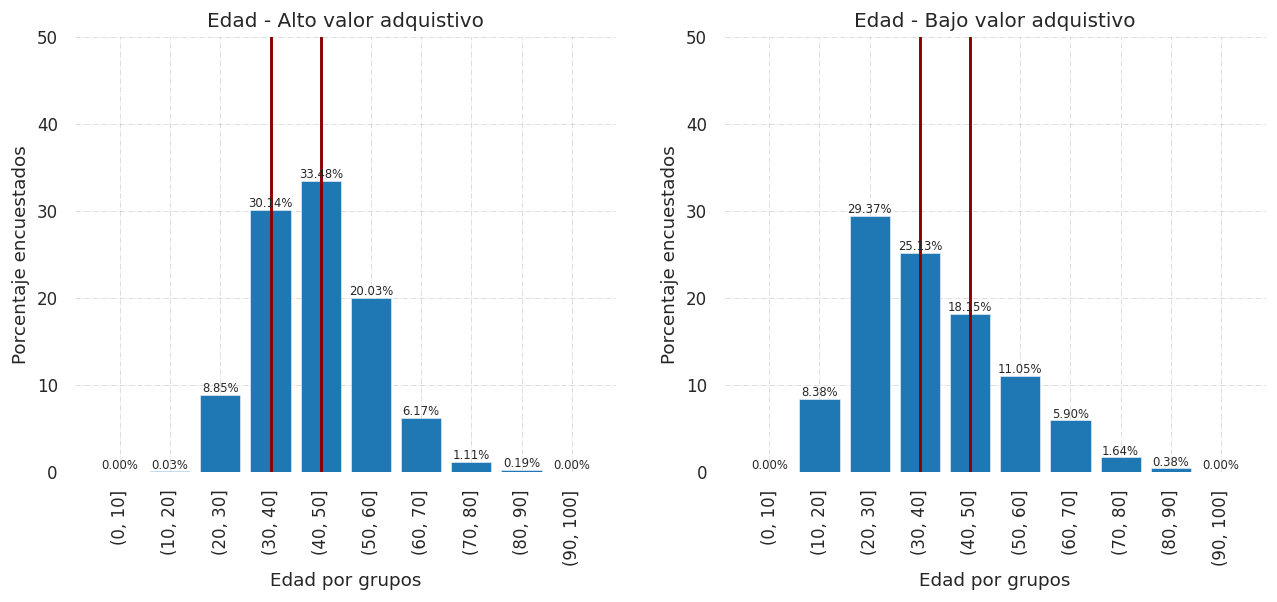

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)

df_alto_valor = df[df.tiene_alto_valor_adquisitivo == 1]
df_bajo_valor = df[df.tiene_alto_valor_adquisitivo == 0]

rango_edades =  np.arange(0,110,10)
cantidad_Altos_en_rango = pd.Series(pd.cut(df_alto_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_rango = pd.Series(pd.cut(df_bajo_valor['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()

ploted = axes[0].bar(cantidad_Altos_en_rango.index.astype(str), cantidad_Altos_en_rango.values)
ploted2 = axes[1].bar(cantidad_Bajos_en_rango.index.astype(str), cantidad_Bajos_en_rango.values)

for plot in [(ploted,axes[0]), (ploted2,axes[1])]:
    for rect in plot[0]:
        height = rect.get_height()
        plot[1].text(rect.get_x() + rect.get_width()/2., height, 
                '%0.2f%%' % float(height),
                ha='center', va='bottom', size=7)
        
    plot[1].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
    plot[1].tick_params('x',labelrotation=90)
    plot[1].set_ylabel("Porcentaje encuestados")
    plot[1].set_xlabel("Edad por grupos")
    plot[1].set_yticks(np.arange(0,60, 10))
    plot[1].axvline(x=4, color="darkred") # ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA
    plot[1].axvline(x=3, color="darkred") # ESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VAESTO NO VA

axes[0].set_title("Edad - Alto valor adquistivo")
axes[1].set_title("Edad - Bajo valor adquistivo")

plt.show()


Algo que podemos identificcar de estas variables es que a medida que uno incrementa su edad, es decir, de 30 hasta los 50 años, empieza a tener un aumento de valor adquisitivo, y una bajada de bajo valor adquisitivo. 

Posterior a lo 50 años, tanto el valor adquisitivo alto y bajo empieza a decrecer por tener menor encuestados en esos rangos

Pero lo interesante, y que podemos concluir es que si pertences a un rango de edad [30, 50] uno es mas proppenso a tener mayor nivel adquisitivo

Aunque no parece algo muuy interesante si tenemos en cuenta que 

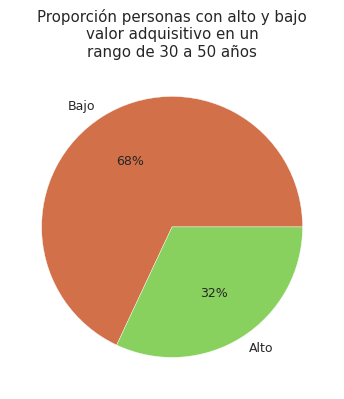

In [20]:
plt.figure(figsize=(6.4, 4.8), dpi=90)
plt.title('Proporción personas con alto y bajo\nvalor adquisitivo en un\nrango de 30 a 50 años')
plt.pie(df[(df['edad'] >= 30) & (df['edad'] <= 50)].tiene_alto_valor_adquisitivo.value_counts(normalize=True), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
plt.ylabel('')
plt.show()

Casi un 32% de éste grupo de eades de mantiene alto valor adquisito. 

En conclusión, y respondiendo nuestra pregunta *¿Hay un rango de edades que dé indicios de tener alto valor adquisitivo?*. La rspuesta que logramos obtener es que no, en rangos de edades caracteristicos no parece ser determinante para tener un alto significativamente alto del valor adquisitivo.

#### Jugando con baseline -- NO GUAIRSE MUCHO, FUERON PRUEBAS!

In [21]:
def age_accuracy_interactive(max_age, min_age):
    if (max_age >= min_age):
        pred_by_age_LA_POSTA = ((df['edad'] >= min_age) & (df['edad'] <= max_age)).astype(np.ubyte)
        print('\nAccuracy with age [',min_age,',',max_age,']:', accuracy_score(df.tiene_alto_valor_adquisitivo, pred_by_age_LA_POSTA))
        pred_by_age_LA_POSTA.value_counts()
        display(df[(df['edad'] >= min_age) & (df['edad'] <= max_age)].tiene_alto_valor_adquisitivo.value_counts())
        plt.pie(df[(df['edad'] >= min_age) & (df['edad'] <= max_age)].tiene_alto_valor_adquisitivo.value_counts(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
    else:
        print("Edad minima nunca puede ser mayor a edad maxima")
        
inter = interactive(
    age_accuracy_interactive,
    max_age=IntSlider(min=0, max=100, value=50), # "value" is a initial default value
    min_age=IntSlider(min=0, max=100, value=30), # "value" is a initial default value
)
display(inter)

interactive(children=(IntSlider(value=50, description='max_age'), IntSlider(value=30, description='min_age'), …

#### ¿Y si separamos estos grupos por genero?

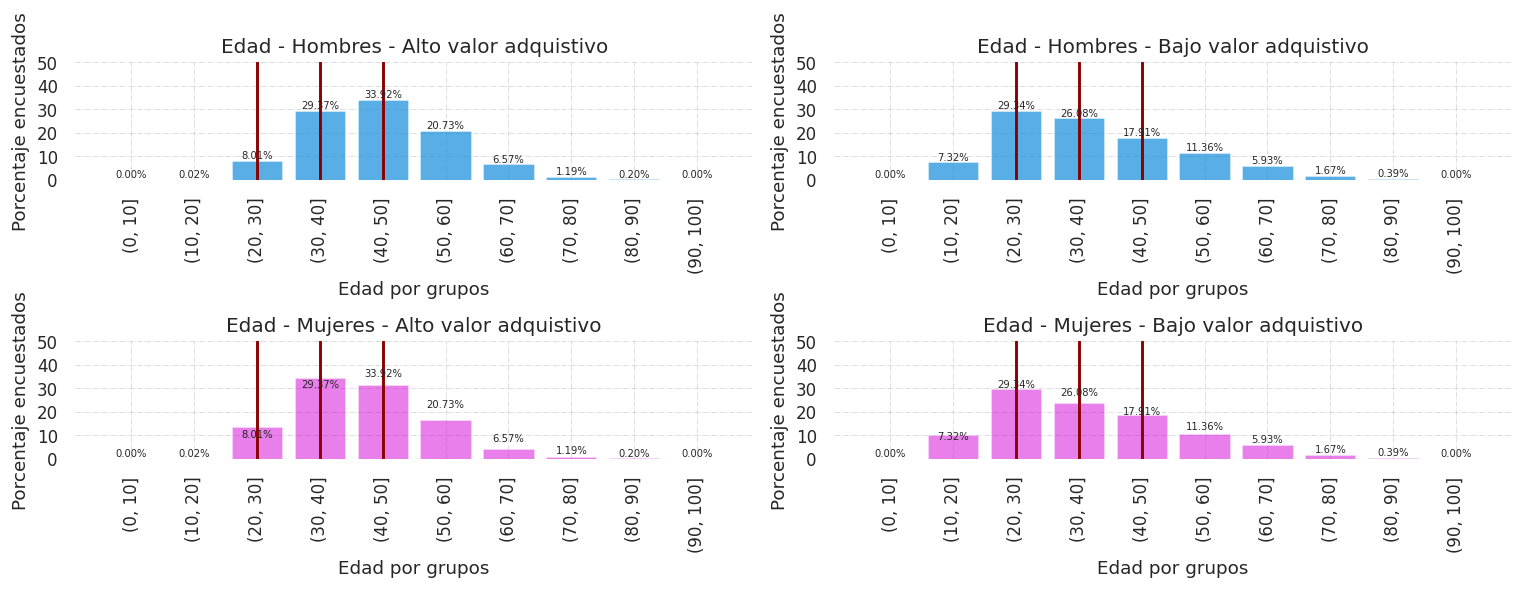

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[6.4 * 2, 4.8], dpi=120)

df_alto_valor_man = df[(df.tiene_alto_valor_adquisitivo == 1) & (df.genero == 'hombre')]
df_bajo_valor_man = df[(df.tiene_alto_valor_adquisitivo == 0) & (df.genero == 'hombre')]

df_alto_valor_woman = df[(df.tiene_alto_valor_adquisitivo == 1) & (df.genero == 'mujer')]
df_bajo_valor_woman = df[(df.tiene_alto_valor_adquisitivo == 0) & (df.genero == 'mujer')]

rango_edades =  np.arange(0,110,10)
cantidad_Altos_en_rango_man = pd.Series(pd.cut(df_alto_valor_man['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_rango_man = pd.Series(pd.cut(df_bajo_valor_man['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()


cantidad_Altos_en_woman = pd.Series(pd.cut(df_alto_valor_woman['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()
cantidad_Bajos_en_woman = pd.Series(pd.cut(df_bajo_valor_woman['edad'], bins = rango_edades).value_counts(normalize=True)*100).sort_index()


ploted = axes[0][0].bar(cantidad_Altos_en_rango_man.index.astype(str), cantidad_Altos_en_rango_man.values, color = "#128CDB",alpha=0.7)
ploted2 = axes[0][1].bar(cantidad_Bajos_en_rango_man.index.astype(str), cantidad_Bajos_en_rango_man.values,color = "#128CDB",alpha=0.7)

ploted3 = axes[1][0].bar(cantidad_Altos_en_woman.index.astype(str), cantidad_Altos_en_woman.values,color = "#D300D8",alpha=0.5)
ploted4 = axes[1][1].bar(cantidad_Bajos_en_woman.index.astype(str), cantidad_Bajos_en_woman.values,color = "#D300D8",alpha=0.5)

for plot in [(ploted,axes[0][0]), (ploted2,axes[0][1]),(ploted,axes[1][0]), (ploted2,axes[1][1])]:
    for rect in plot[0]:
        height = rect.get_height()
        plot[1].text(rect.get_x() + rect.get_width()/2., height, 
                '%0.2f%%' % float(height),
                ha='center', va='bottom', size=6)
        
    plot[1].grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
    plot[1].tick_params('x',labelrotation=90)
    plot[1].set_ylabel("Porcentaje encuestados")
    plot[1].set_xlabel("Edad por grupos")
    plot[1].set_yticks(np.arange(0,60, 10))
    plot[1].axvline(x=4, color="darkred") # ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA
    plot[1].axvline(x=3, color="darkred") # ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA
    plot[1].axvline(x=2, color="darkred") # ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA ESTO NO VA

axes[0][0].set_title("Edad - Hombres - Alto valor adquistivo")
axes[0][1].set_title("Edad - Hombres - Bajo valor adquistivo")
axes[1][0].set_title("Edad - Mujeres - Alto valor adquistivo")
axes[1][1].set_title("Edad - Mujeres - Bajo valor adquistivo")
fig.tight_layout()
plt.show()


Se puede notar ese leve aumento del valor adquisitivo en mujeres de 30 a 40 años, pero en caso de los hombres esto ocurre entre los 30 y 50 años. Posterior a esto, comienza a decrecer. 

Guiemonos con el grafico de torta para ver si hubo un aumento de alto valor adquisitivo en este caso separandolos por generos:

##### DUDANDO DEL GRAFICO!!!!!!! NO SE SI REPRESENTA BIEN EL % MM  -- IGNORAR EL SLIDE INTERCATIVO, SOLO ES PARA JUGAR!!

In [23]:
def age_accuracy_interactive(max_age, min_age, max_age_woman, min_age_woman):
    if (max_age >= min_age | max_age_woman>=min_age_woman):
        condicion_mujeres = (df['edad'] >= min_age_woman) & (df['edad'] <= max_age_woman ) & (df['genero'] == 'mujer')
        condicion_varones = (df['edad'] >= min_age) & (df['edad'] <= max_age ) & (df['genero'] == 'hombre')
        pred_final = ( condicion_varones | condicion_mujeres ).astype(np.ubyte)
        print('Accuracy:', accuracy_score(df.tiene_alto_valor_adquisitivo, pred_final))
        plt.figure(figsize=(6.4, 4.8), dpi=90)
        plt.title('Proporción personas con alto y bajo\nvalor adquisitivo en un\nrango de 30 a 50 años separados por genero')
        display(df[condicion_varones | condicion_mujeres].tiene_alto_valor_adquisitivo.value_counts())
        plt.pie(df[condicion_varones | condicion_mujeres].tiene_alto_valor_adquisitivo.value_counts(), labels= ['Bajo', 'Alto'], colors=['#D17049',"#89D15E"],autopct='%1.0f%%')
    else:
        print("Edad minima nunca puede ser mayor a edad maxima")
        
inter = interactive(
    age_accuracy_interactive,
    max_age=IntSlider(min=0, max=100, value=50), # "value" is a initial default value
    min_age=IntSlider(min=0, max=100, value=40), # "value" is a initial default value
    max_age_woman=IntSlider(min=0, max=100, value=40), # "value" is a initial default value
    min_age_woman=IntSlider(min=0, max=100, value=30), # "value" is a initial default value
)
display(inter)

interactive(children=(IntSlider(value=50, description='max_age'), IntSlider(value=40, description='min_age'), …

#### [DUDANDO] RESPONDIENDO A LA PREGUNTA

Podemos observar una mejora mayor de solo 3%. 

¿Podria ser una variable interesante para la hora del construcción del baseline? Pues mejoró el accurracy...


¿**Mi gran duda** es que pasa si te da 90% de alto valor adquisitivo pero con 10 personas?

Aca parece coherente ese 35% pero sigue siendo bajo... pero serviria para estimar, porque el value_counts me devuelve casi 7000 personas..

Pero con 32% de antes, tenias casi 15000 personas, pero incluias ambos generos!
Acá con 35% tenes casi 7000 personas, pero separastes los generos. La condicion del OR evalua ambos y éso me confunde... no se.

Ademas,

el accurracy claramente me dio mejor si evaluo con el 35%... quizás debamos quedarnos con la que mejor acurracy nos quede, cierto? Pero tener en cuenta la cantidad encuestados? 

*(creo que en terminos de arbol de decision, seria tener cuidado con el min_samples, pero no lo se, no lo tengo bien estudiado a ese tema)*



## **ANOTANDO TAREAS PARA LAS DE EDUCACIÓN:**

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29096 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            29096 non-null  int64 
 1   barrio                                      28516 non-null  object
 2   categoria_de_trabajo                        27464 non-null  object
 3   edad                                        29096 non-null  int64 
 4   educacion_alcanzada                         29096 non-null  object
 5   estado_marital                              29096 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  29096 non-null  int64 
 7   genero                                      29096 non-null  object
 8   horas_trabajo_registradas                   29096 non-null  int64 
 9   religion                                    29096 non-null  object
 10  rol_familiar_registrad

Features a relacionar, visualizar e indagar

* anios_estudiados
* educacion_alcanzada
    * separala en jaridn-primaria-secundaria-

En estas features las relacionaré seguramente con las ya estudiadas en otras subsecciones:

* Principalmente:
    * tiene_alto_valor_adquisitivo 
    * ganancia_perdida_declarada_bolsa_argentina
    * edad
    * genero
    
* Si encuentro relacion piola, capaz las muestro:
    * estado_marital
    * rol_familiar_registrado
    * trabajo
    * religion
        

## ¿Los encuestados tienen elvada cantidad de años estudiados?


In [25]:
df.anios_estudiados.nunique()

16

In [26]:
df.anios_estudiados.value_counts()

13    8886
14    6378
17    4810
18    1653
15    1331
11    1056
16    1053
10     867
8      629
19     566
9      507
12     414
20     402
6      328
4      166
1       50
Name: anios_estudiados, dtype: int64

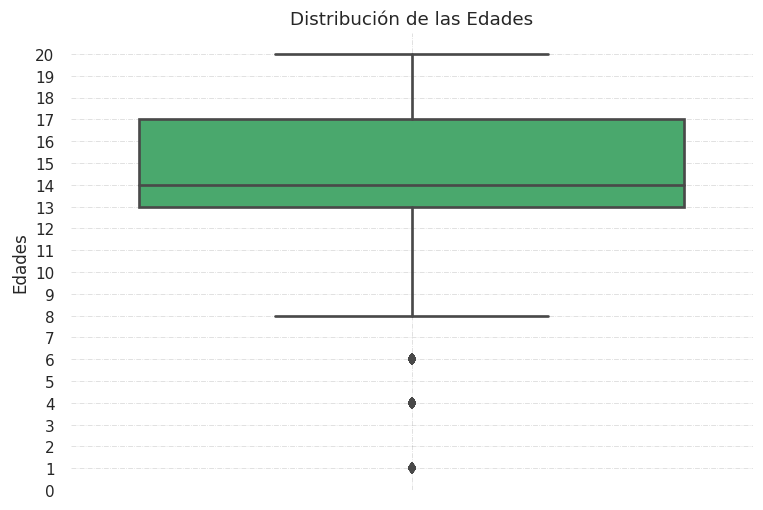

In [27]:
plt.figure(dpi=110)
plt.title("title")
sns.boxplot(
    y=df.anios_estudiados.values,
    color=(0.23, 0.72, 0.41),

)
plt.title("Distribución de las Edades")
plt.ylabel("Edades")
plt.yticks(np.arange(0,21, 1))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)

plt.show()


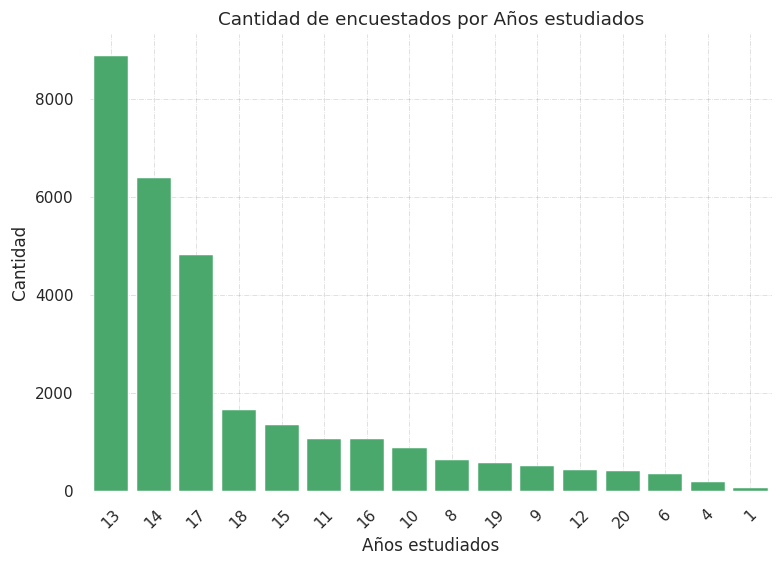

In [28]:
plt.figure(dpi=110)
sns.countplot(
    x="anios_estudiados",
    data=df,
    order=df["anios_estudiados"].value_counts(normalize=True).index,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Años estudiados")
plt.title("Cantidad de encuestados por Años estudiados")
plt.xticks(rotation=45)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

## ¿Como son los niveles de educacion alcanzados?


In [29]:
df.educacion_alcanzada.nunique()

16

In [30]:
df.educacion_alcanzada.value_counts()

4_anio                8886
5_anio                6378
universidad_3_anio    4810
universidad_4_anio    1653
universidad_1_anio    1331
2_anio                1056
universidad_2_anio    1053
1_anio                 867
7-8_grado              629
universiada_5_anio     566
9_grado                507
3_anio                 414
universiada_6_anio     402
5-6_grado              328
1-4_grado              166
preescolar              50
Name: educacion_alcanzada, dtype: int64

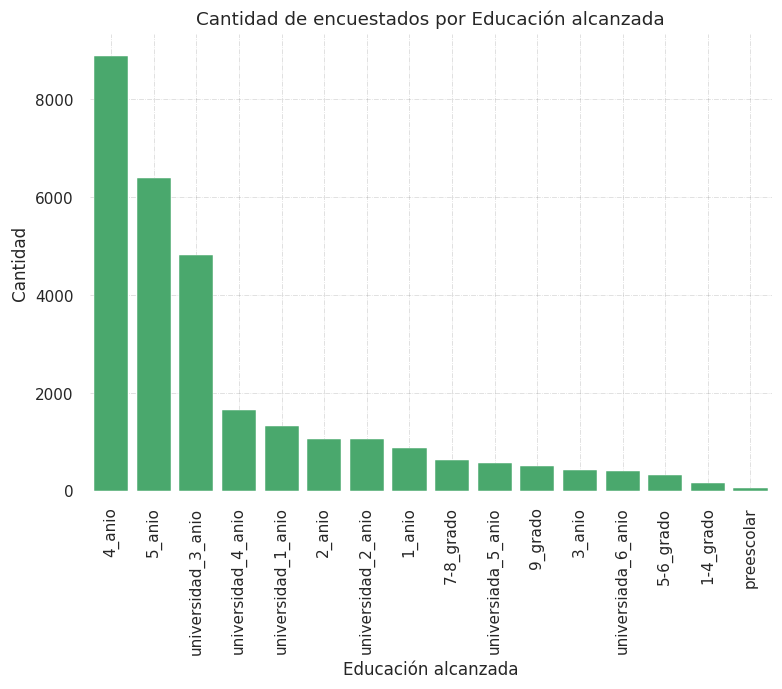

In [31]:
plt.figure(dpi=110)
sns.countplot(
    x="educacion_alcanzada",
    data=df,
    order=df["educacion_alcanzada"].value_counts(normalize=True).index,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Educación alcanzada")
plt.title("Cantidad de encuestados por Educación alcanzada")
plt.xticks(rotation=90)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

In [32]:
df.educacion_alcanzada.unique()

array(['universidad_3_anio', '4_anio', '2_anio', 'universidad_4_anio',
       '9_grado', '5_anio', 'universidad_2_anio', 'universidad_1_anio',
       '7-8_grado', 'universiada_6_anio', 'universiada_5_anio',
       '5-6_grado', '1_anio', '1-4_grado', 'preescolar', '3_anio'],
      dtype=object)

In [33]:
universitario = 'Universitario'
secundaria = 'Secundaria'
primaria = 'Primaria'
jardin = 'Jardin'

def agrupacion_educacion(educacion_alcanzada):
    return {'universidad_3_anio':universitario, '4_anio':secundaria, '2_anio':secundaria,  'universidad_4_anio':universitario, 
       '9_grado':primaria, '5_anio':secundaria,  'universidad_2_anio':universitario,  'universidad_1_anio':universitario, 
       '7-8_grado':primaria, 'universiada_6_anio':universitario,  'universiada_5_anio':universitario, 
       '5-6_grado':primaria, '1_anio':secundaria,  '1-4_grado':primaria, 'preescolar':jardin, '3_anio':secundaria}[educacion_alcanzada]


df['Educacion alcanzada generalizada'] = df.educacion_alcanzada.apply(agrupacion_educacion)

In [34]:
df['Educacion alcanzada generalizada'].value_counts()

Secundaria       17601
Universitario     9815
Primaria          1630
Jardin              50
Name: Educacion alcanzada generalizada, dtype: int64

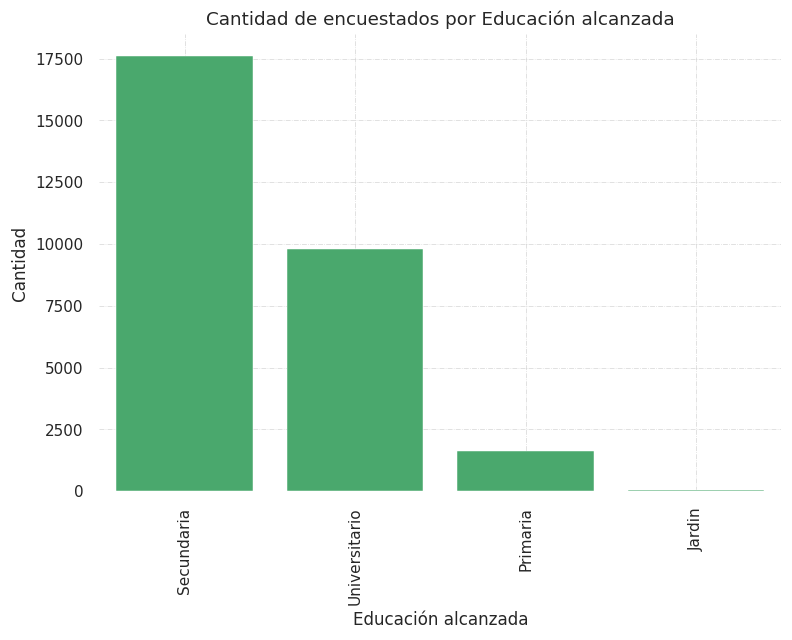

In [35]:
plt.figure(dpi=110)
sns.countplot(
    x="Educacion alcanzada generalizada",
    data=df,
    order=df['Educacion alcanzada generalizada'].value_counts(normalize=True).index,
    color=(0.23, 0.72, 0.41),
    orient= "v",
)
plt.ylabel("Cantidad")
plt.xlabel("Educación alcanzada")
plt.title("Cantidad de encuestados por Educación alcanzada")
plt.xticks(rotation=90)
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

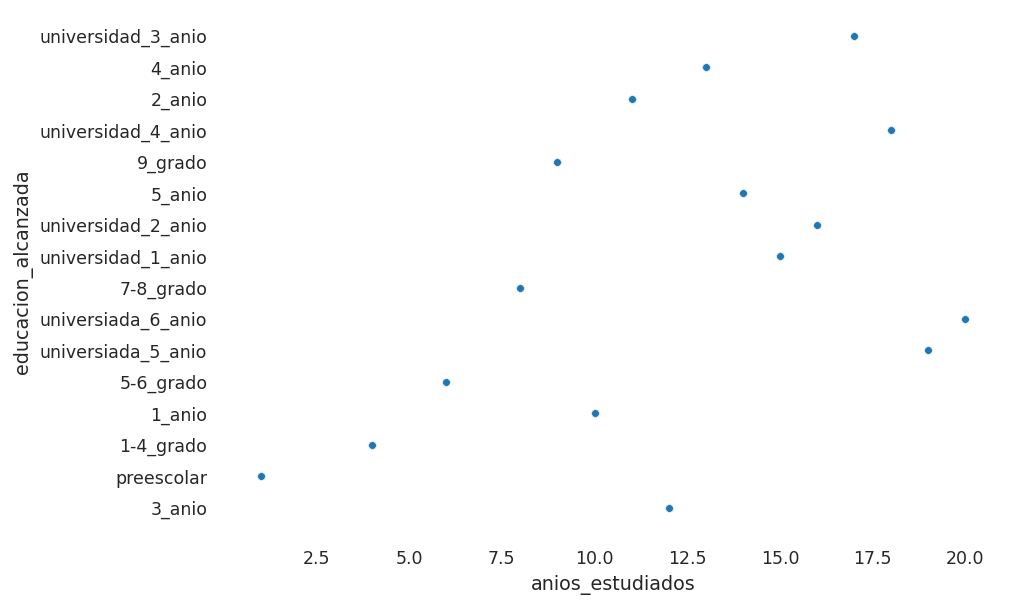

In [36]:


plt.figure(dpi=125)
sns.scatterplot(
    
    x=df.anios_estudiados,
    y=df.educacion_alcanzada,
    s=20,

)

plt.show()

### ¿Como se relaciona la cantidad de años estudiados segun el nivel de educacion alcanzada?

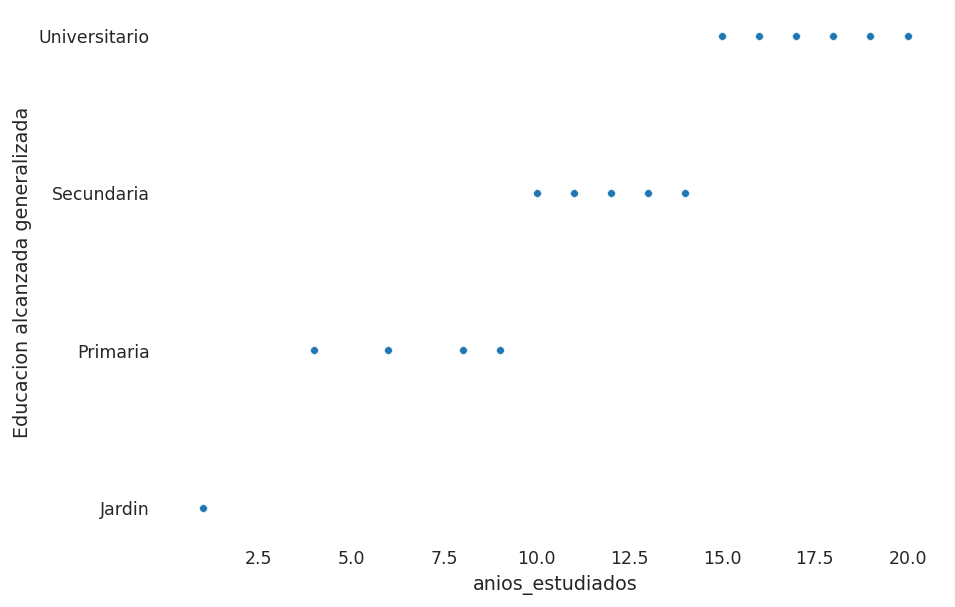

In [37]:


plt.figure(dpi=125)
sns.scatterplot(
    
    x=df.anios_estudiados,
    y=df['Educacion alcanzada generalizada'],
    s=20,

)

plt.show()

In [38]:
plt.figure(dpi=150)
#plt.title("Distribución del salario NETO según\nsi tiene gente a cargo en Argentina")
sns.boxplot(
    data=df,
    y=df.anios_estudiados,
    x='Educacion alcanzada generalizada'
#plt.xticks(rotation=45)
plt.yticks(np.arange(0,21, 1))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

SyntaxError: invalid syntax (<ipython-input-38-df25c9499ba7>, line 8)

In [ ]:
def generalizar_empleados_publicos(categoria):
    if categoria in ['empleado_municipal','empleado_provincial','empleadao_estatal']:
        return 'empleado_publico'
    return categoria

In [ ]:
df.educacion_alcanzada.value_counts()

In [ ]:
def agrupacion_educacion(categoria):
    if categoria in ['universidad_4_anio','universiada_5_anio','universiada_6_anio']:
        return 'Universitario - (3,6] grado'
    if categoria in ['universidad_1_anio','universidad_2_anio','universidad_3_anio']:
        return 'Universitario - [1,3] grado'
    if categoria in ['1_anio','2_anio','3_anio']:
        return 'Secundario - [1,3] grado'
    if categoria in ['4_anio','5_anio','6_anio']:
        return 'Secundario - (3,6] grado'
    if categoria in ['1-4_grado','5-6_grado']:
        return 'Primaria - [1,6] grado'
    if categoria in ['7-8_grado','9_grado']:
        return 'Primaria - (6,9] grado'
    if categoria in ['preescolar']:
        return 'Jardin'    
    return categoria


df['Educacion alcanzada generalizada distinta'] = df.educacion_alcanzada.apply(agrupacion_educacion)

In [ ]:
plt.figure(dpi=150)
#plt.title("Distribución del salario NETO según\nsi tiene gente a cargo en Argentina")
sns.boxplot(
    data=df,
    y=df.anios_estudiados,
    x='Educacion alcanzada generalizada distinta')
plt.xticks(rotation=70)
plt.yticks(np.arange(0,21, 1))
plt.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.3)
plt.show()

### ¿Cuanto menor años estudiados y mayor nivel de educacion alcanzado, tiende a tener alto valor adquisiivo de la persona? 

In [ ]:
#sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=120)
pivoted = pd.pivot_table(
    data = df, 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'anios_estudiados',
)
pivoted.sort_index(ascending =  False, inplace = True)
pivoted = pivoted.replace(np.nan,0)
g = sns.heatmap(pivoted, annot=True, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion alto valor adquisitivos\nsegun Años estudiados y Educacion Alcanzada")

plt.show()

In [ ]:
def agrupacion_anios_estudiados(categoria):
    if categoria in np.arange(1,5).tolist():
        return '(0,4]'
    if categoria in np.arange(4,8).tolist():
        return '(4,7]'
    if categoria in np.arange(7,11).tolist():
        return '(7,10]'
    if categoria in np.arange(10,16).tolist():
        return '(10,15]'
    if categoria in np.arange(16,21).tolist():
        return '(15,20]'
    return categoria


df['Anios estudiados generalizada'] = df.anios_estudiados.apply(agrupacion_anios_estudiados)

In [ ]:
#sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=120)
pivoted = pd.pivot_table(
    data = df, 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted.sort_index(ascending =  False, inplace = True)
pivoted = pivoted.replace(np.nan,0)
g = sns.heatmap(pivoted, annot=True, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion Alto alor adquisitivos\nsegun Años Estudiados y Educacion Alcanzada")

plt.show()

#### Adicionalmente a la pregunta inicial: ¿y si que el contribuyente opera en la bolsa?

In [ ]:
#sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=120)
pivoted = pd.pivot_table(
    data = df[(df['ganancia_perdida_declarada_bolsa_argentina']!=0)], 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted.sort_index(ascending =  False, inplace = True)
pivoted = pivoted.replace(np.nan,0)
g = sns.heatmap(pivoted, annot=True, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion alto valor adquisitivos\nsegun años estudiados y eudcacion alcanzada\ny participando en la bolsa")

plt.show()

##### Si en vez de participar en la bolsa,  tiene estado martial 'sin_matrimonio'?

In [ ]:
#sns.set(rc={'figure.figsize':(8,7)})
plt.figure(dpi=120)
pivoted = pd.pivot_table(
    data =df[(df.estado_marital == 'sin_matrimonio')], 
    index ='Educacion alcanzada generalizada distinta', 
    values = 'tiene_alto_valor_adquisitivo', 
    columns = 'Anios estudiados generalizada',
)
pivoted.sort_index(ascending =  False, inplace = True)
pivoted = pivoted.replace(np.nan,0)
g = sns.heatmap(pivoted, annot=True, cmap="Wistia", linewidths=.5)
g.set_ylabel("Educacion alcanzada")
g.set_xlabel("Años estudiados")
g.set_title("Proporcion alto valor adquisitivos\nsegun años estudiados y educacion alcanzada\ny estando sin matrimonio")

plt.show()

### ¿El interes por acudir a la bolsa Argentina, tiene que ver con el nivel educativo de la persona?

In [ ]:
df['declaro_actividad_en_bolsa'] = df['ganancia_perdida_declarada_bolsa_argentina'] != 0
df['declaro_actividad_en_bolsa'].replace(False,0)
plt.figure(dpi = (100))


bar_plot = sns.countplot(data=df, x='Educacion alcanzada generalizada distinta', hue='declaro_actividad_en_bolsa')
legend = bar_plot.get_legend()
legend.set_title('¿Declaro actividad en bolsa?')
labels = legend.texts
labels[0] = 'No'
labels[1] = 'Si'
bar_plot.set_ylabel('Cantidad de encuestados')
plt.xticks(rotation=70)




plt.show()

### ¿Hay alguna relacion la religion?

* **Investigar como relacionar categoricas sin acuidr a bar plots a cada rato**
    * gruopby? apply? conversion?